In [1]:
from PIL import Image
import tensorflow as tf
import cv2
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt


2023-12-31 02:21:40.220026: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 02:21:40.220053: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 02:21:40.220068: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 02:21:40.224521: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


In [2]:
def _build_keypoint_preprocessing(input_shape, backbone):
    """Builds the preprocessing function for the Field Keypoint Detector Model.

    """
    sm_preprocessing = sm.get_preprocessing(backbone)

    def preprocessing(input_img, **kwargs):

        to_normalize = False if np.percentile(input_img, 98) > 1.0 else True

        if len(input_img.shape) == 4:
            print(
                "Only preprocessing single image, we will consider the first one of the batch"
            )
            image = input_img[0] * 255.0 if to_normalize else input_img[0] * 1.0
        else:
            image = input_img * 255.0 if to_normalize else input_img * 1.0

        image = cv2.resize(image, input_shape)
        image = sm_preprocessing(image)
        return image

    return preprocessing

In [3]:
class KeypointDetectorModel:
    """Class for Keras Models to predict the keypoint in an image. These keypoints can then be used to
    compute the homography.

    Arguments:
        backbone: String, the backbone we want to use
        model_choice: The model architecture. ('FPN','Unet','Linknet')
        num_classes: Integer, number of mask to compute (= number of keypoints)
        input_shape: Tuple, shape of the model's input 
    Call arguments:
        input_img: a np.array of shape input_shape
    """

    def __init__(
        self,
        backbone="efficientnetb3",
        model_choice="FPN",
        num_classes=29,
        input_shape=(320, 320),
    ):

        self.input_shape = input_shape
        self.classes = [str(i) for i in range(num_classes)] + ["background"]
        self.backbone = backbone

        n_classes = len(self.classes)
        activation = "softmax"

        if model_choice == "FPN":
            self.model = sm.FPN(
                self.backbone,
                classes=n_classes,
                activation=activation,
                input_shape=(input_shape[0], input_shape[1], 3),
                encoder_weights="imagenet",
            )
        else:
            self.model = None
            print("{} is not used yet".format(model_choice))

        self.preprocessing = _build_keypoint_preprocessing(input_shape, backbone)

    def __call__(self, input_img):

        img = self.preprocessing(input_img)
        pr_mask = self.model.predict(np.array([img]))
        return pr_mask

    def load_weights(self, weights_path):
        try:
            self.model.load_weights(weights_path)
            print("Succesfully loaded weights from {}".format(weights_path))
        except:
            orig_weights = "from Imagenet"
            print(
                "Could not load weights from {}, weights will be loaded {}".format(
                    weights_path, orig_weights
                )
            )

In [4]:
def _get_keypoints_from_mask(mask, treshold=0.9):
    """From a list of mask, compute the mapping of each keypoints to their location

    Arguments:
        mask: np.array of shape (nb_of_mask) x (mask_shape)
        treshold: Treshold of intensity to decide if a pixels is considered or not
    Returns:
        keypoints: Dict, mapping each keypoint id to its location
    Raises:
        
    """
    keypoints = {}
    indexes = np.argwhere(mask[:, :, :-1] > treshold)
    for indx in indexes:
        id_kp = indx[2]
        if id_kp in keypoints.keys():
            keypoints[id_kp][0].append(indx[0])
            keypoints[id_kp][1].append(indx[1])
        else:
            keypoints[id_kp] = [[indx[0]], [indx[1]]]

    for id_kp in keypoints.keys():
        mean_x = np.mean(np.array(keypoints[id_kp][0]))
        mean_y = np.mean(np.array(keypoints[id_kp][1]))
        keypoints[id_kp] = [mean_y, mean_x]
    return keypoints

def collinear(p0, p1, p2, epsilon=0.001):
    x1, y1 = p1[0] - p0[0], p1[1] - p0[1]
    x2, y2 = p2[0] - p0[0], p2[1] - p0[1]
    return abs(x1 * y2 - x2 * y1) < epsilon

In [5]:

INIT_HOMO_MAPPER = {
    0: [3, 3],
    1: [3, 66],
    2: [51, 65],
    3: [3, 117],
    4: [17, 117],
    5: [3, 203],
    6: [17, 203],
    7: [3, 255],
    8: [51, 254],
    9: [3, 317],
    10: [160, 3],
    11: [160, 160],
    12: [160, 317],
    13: [317, 3],
    14: [317, 66],
    15: [270, 66],
    16: [317, 118],
    17: [304, 118],
    18: [317, 203],
    19: [304, 203],
    20: [317, 255],
    21: [271, 255],
    22: [317, 317],
    23: [51, 128],
    24: [51, 193],
    25: [161, 118],
    26: [161, 203],
    27: [270, 128],
    28: [269, 192],
}



In [6]:
import six
def _points_from_mask(mask, treshold=0.9):
    """From a list of mask, compute src and dst points from the image and the 2D view of the image

    Arguments:
        mask: np.array of shape (nb_of_mask) x (mask_shape)
        treshold: Treshold of intensity to decide if a pixels is considered or not
    Returns:
        src_pts, dst_pts: Location of src and dst related points
    Raises:
        
    """
    list_ids = []
    src_pts, dst_pts = [], []
    available_keypoints = _get_keypoints_from_mask(mask, treshold)

    ### new
    if 25 in available_keypoints and 26 in available_keypoints:
        p1 = available_keypoints[25]
        p2 = available_keypoints[26]

        midpoint_x = (p1[0] + p2[0]) // 2
        midpoint_y = (p1[1] + p2[1]) // 2


        distance_y =  (p2[1] - midpoint_y)

        right_pointx = (midpoint_x + distance_y)*1.3
        right_pointy = midpoint_y

        if right_pointx > 0 and right_pointx < 320:
            available_keypoints[29] = [right_pointx,right_pointy]
            INIT_HOMO_MAPPER[29] = [190, 160]

        left_pointx = (midpoint_x - distance_y)*0.7
        left_pointy = midpoint_y

        if left_pointx > 0 and left_pointx < 320:
            available_keypoints[30] = [left_pointx,left_pointy]
            INIT_HOMO_MAPPER[30] = [130, 160]

        if 30  in INIT_HOMO_MAPPER and 29 in INIT_HOMO_MAPPER:
            del available_keypoints[11]



    ###

    for id_kp, v in six.iteritems(available_keypoints):
        src_pts.append(v)
        dst_pts.append(INIT_HOMO_MAPPER[id_kp])
        list_ids.append(id_kp)
    src, dst = np.array(src_pts), np.array(dst_pts)

    ### Final test : return nothing if 3 points are colinear and the src has just 4 points 
    test_colinear = False
    if len(src) == 4:
        if collinear(dst_pts[0], dst_pts[1], dst_pts[2]) or collinear(dst_pts[0], dst_pts[1], dst_pts[3]) or collinear(dst_pts[1], dst_pts[2], dst_pts[3]) :
          test_colinear = True
    src = np.array([]) if test_colinear else src
    dst = np.array([]) if test_colinear else dst
    
    return src, dst

In [7]:
def get_perspective_transform_cv(src, dst):
    """Get the homography matrix between src and dst

    Arguments:
        src: np.array of shape (B,X,2) or (X,2), the X>3 original points per image
        dst: np.array of shape (B,X,2) or (X,2), the X>3 corresponding points per image
    Returns:
        M: np.array of shape (B,3,3) or (3,3), each homography per image
    Raises:

    """
    if len(src.shape) == 2:
        M, _ = cv2.findHomography(src, dst, cv2.RANSAC, 5)
    else:
        M = []
        for src_, dst_ in zip(src, dst):
            M.append(cv2.findHomography(src_, dst_, cv2.RANSAC, 5)[0])
        M = np.array(M)
    return M


In [8]:

def warp_image_cv(img, H, out_shape=None):
    """Apply an homography to a np.array

    Arguments:
        img: np.array of shape (B,H,W,C) or (H,W,C)
        H: Tensor of shape (B,3,3) or (3,3), the homography
        out_shape: Tuple, the wanted shape of the out image
    Returns:
        A np.array of shape (B) x (out_shape) or (B) x (img.shape), the warped image 
    Raises:
        ValueError: If img and H batch sizes are different
    """
    if out_shape is None:
        out_shape = img.shape[-3:-1] if len(img.shape) == 4 else img.shape[:-1]
    if len(img.shape) == 3:
        return cv2.warpPerspective(img, H, dsize=out_shape)
    else:
        if img.shape[0] != H.shape[0]:
            raise ValueError(
                "batch size of images ({}) do not match the batch size of homographies ({})".format(
                    img.shape[0], H.shape[0]
                )
            )
        out_img = []
        for img_, H_ in zip(img, H):
            out_img.append(cv2.warpPerspective(img_, H_, dsize=out_shape))
        return np.array(out_img)

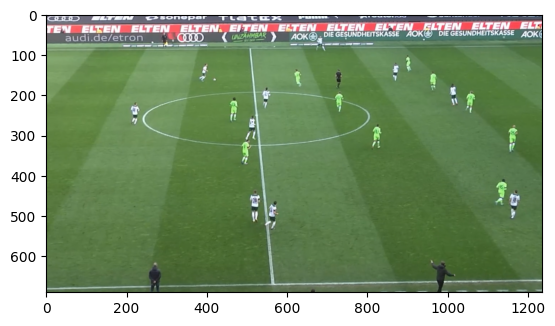

In [9]:
img = cv2.cvtColor(cv2.imread('./test_center.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img)

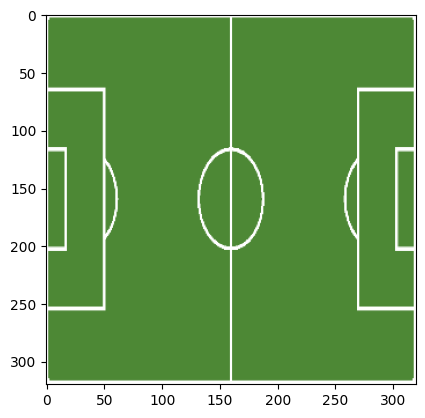

In [10]:
template = cv2.cvtColor(cv2.imread('./template_2.png'), cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (320,320))
plt.imshow(template)

In [11]:
kp_model = KeypointDetectorModel(
    backbone='efficientnetb3', num_classes=29, input_shape=(320, 320),
)

# WEIGHTS_PATH = (
#     "https://storage.googleapis.com/narya-bucket-1/models/keypoint_detector.h5"
# )

kp_model.load_weights("./keypoint_detector.h5")

2023-12-31 02:21:54.396198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-31 02:21:54.419573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-31 02:21:54.419717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Succesfully loaded weights from ./keypoint_detector.h5


In [12]:

pr_mask = kp_model(img)

2023-12-31 02:21:58.198433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-12-31 02:21:58.249683: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-31 02:21:58.555448: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 3s 3s/step


In [13]:
src,dst = _points_from_mask(pr_mask[0])

In [14]:
src,dst

(array([[133.        ,  41.5       ],
        [135.83333333,  90.83333333],
        [138.875     , 152.125     ],
        [218.5625    , 121.        ],
        [ 74.1125    , 121.        ]]),
 array([[160,   3],
        [161, 118],
        [161, 203],
        [190, 160],
        [130, 160]]))

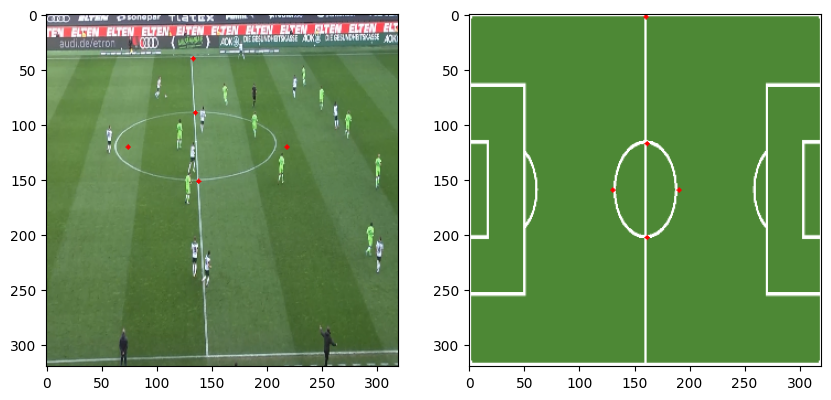

In [15]:
img = cv2.resize(img, (320,320))

img2 = img.copy()
template2 = template.copy()

# create fig with 2 cols and 1 rows
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12))


for s,d in zip(src, dst):
    img2 = cv2.circle(img2, (int(s[0]), int(s[1])), 2, (255, 0, 0), -1)
    template2 = cv2.circle(template2, (int(d[0]), int(d[1])), 2, (255, 0, 0), -1)

ax1.imshow(img2)
ax2.imshow(template2)


In [16]:
H = get_perspective_transform_cv(src,dst)
H

array([[ 9.92037708e+00,  9.70314968e+00, -5.36057751e+02],
       [ 4.65907777e+00,  2.44311179e+01, -1.61131062e+03],
       [ 2.91192360e-02,  6.12011701e-02,  1.00000000e+00]])

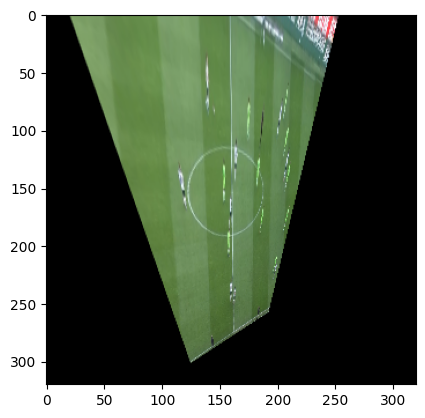

In [17]:
warped = cv2.warpPerspective(img, H, dsize=(320,320))
plt.imshow(warped)

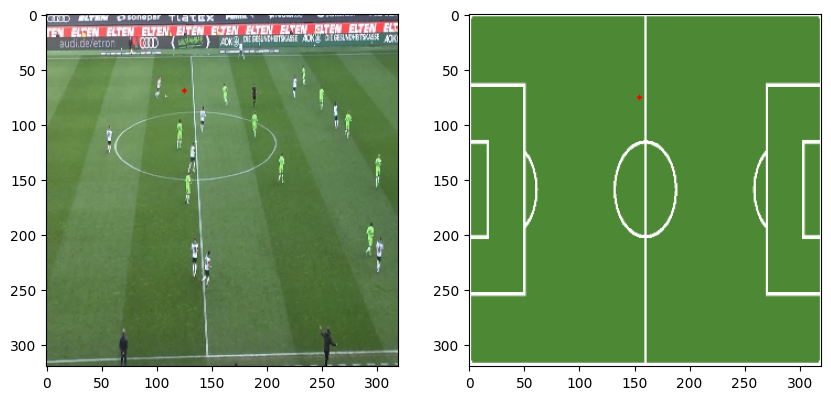

In [19]:

ball_pts = np.array([(125, 70)], dtype=np.float32).reshape(-1, 1, 2)
transformed_pts = cv2.perspectiveTransform(ball_pts, H)[0]

img2 = img.copy()
template2 = template.copy()

# create fig with 2 cols and 1 rows
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12))

img2 = cv2.circle(img2, (int(ball_pts[0][0][0]), int(ball_pts[0][0][1])), 2, (255, 0, 0), -1)
template2 = cv2.circle(template2, (int(transformed_pts[0][0]), int(transformed_pts[0][1])), 2, (255, 0, 0), -1)

ax1.imshow(img2)
ax2.imshow(template2)

## video

In [133]:
from futstats.video.video_utils import VideoConfig, generate_frames, get_video_writer
from tqdm import tqdm


In [134]:
video_writer_homography = get_video_writer(
    target_video_path="../../output_video/ball_path_narya/08fd33_0_warped",
    video_config=VideoConfig(fps=30, width=template.shape[1], height=template.shape[0]),
)

frame_iterator = iter(generate_frames(video_file="../../../../clips/08fd33_0.mp4"))


In [135]:
for iteration, frame in enumerate(tqdm(frame_iterator, total=750)):
    pr_mask = kp_model(frame)
    src_points, dst_points = _points_from_mask(pr_mask[0])
    pred_homo = get_perspective_transform_cv(src,dst)
    warped = cv2.warpPerspective(cv2.resize(frame, (320, 320)), pred_homo, dsize=(320,320))

    plt.imshow(frame)
    video_writer_homography.write(warped)

video_writer_homography.release()

  0%|          | 0/750 [00:00<?, ?it/s]
